In [1]:
import ast
import os
import glob
import numpy as np
import datetime
import xarray as xr
import nc_time_axis
import itertools
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.util as cutil
import cftime
%matplotlib inline

In [2]:


params = {
    'font.size': 10,
    'legend.fontsize': 'small',
    'figure.figsize': (15, 5),
    'axes.labelsize': 'medium',
    'axes.titlesize':'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small'
}
plt.rcParams.update(params)

In [4]:
#plt.rcdefaults()
#datapath = "../../tracker/data"
datapath = "/home/jasperdj/files_rene/"
figpath = "../figures"

In [5]:
# read in and merge data
open_kwargs = {
    'Reference': ('RCP',2002,'ref'), 
    'RCP8.5': ('RCP',2092,'rcp'), 
    'SAI2050': ('SAI',2092,'sai')
}

ds = {exp: [] for exp in open_kwargs}
for exp, (name, year, tag) in open_kwargs.items():
    maxtn = 0
    num_days = 0
    for n in range(1,6):
        fname = f'{name}.started_{year}.00{n}/TC_tracker_results.{tag}.started_{year}.00{n}.nc'
        file = os.path.join(datapath, fname)
        if os.path.exists(file):
            dsi = xr.open_dataset(file, decode_cf=False)
            # # test start
            # for tid in dsi.id.data:
            #     lons = dsi.TC_tracks.isel(data=1).sel(id=tid)
            #     lons[lons>1e30] = np.nan
            #     if not (lons.dropna('dtime').dtime.diff('dtime') == 0.125).all().item():
            #         print(exp, n, tid, lons.values[5:10])
            # # test end
            dsi = (dsi.assign_coords(id=('id',dsi.id.data+maxtn,dsi.id.attrs))
                   .assign_coords(ens=('id',np.ones(dsi.id.size)*n,{'long_name':'ensemble member'})))
            ds[exp].append(dsi)
            maxtn = dsi.id.max().item()
            # times = dsi.TC_tracks.isel(data=0)
            num_days += dsi.num_days
            print(f'{tag.upper()}.00{n}: {dsi.num_days/365:.3f} years, {len(dsi.id)} tracks')
    ds[exp] = xr.concat(ds[exp], data_vars='minimal', dim='id')
    ds[exp]['num_days'] = num_days.assign_attrs({'long_name':'total number of analysed days'})


for k,v in ds.items():
    for i,(desc) in enumerate(v.data.description):
        shortname = desc[:desc.index(':')]
        v[shortname] = v.TC_tracks.isel(data=i).assign_attrs(
            ast.literal_eval(desc[desc.index(':')+1:]))
        v[shortname].data[v[shortname]>1e30] = np.nan
    time = v.time.copy()
    time -= 0.0625 # set to center of CESM time bounds (only for year determination)
    tmask = np.isnan(time)
    time.data = cftime.num2date(time.fillna(0), time.units, time.calendar)
    v['year'] = time.dt.year.where(~tmask, np.nan)
    v['PRECT'].data = v['PRECT']*3.6e6 # m/s to mm/hour
    v['PRECT'].attrs.update({'units':'mm/hour'})


# There are a handful of NaNs in longitude in otherwise fine trajectories
# fixing manually...
for exp in ds:
    for tid in ds[exp].id.data:
        dsi = ds[exp].sel(id=tid)
        if np.isnan(dsi.lon[7]):
            dsi.lon[7] = dsi.lon[6]
            print(f"{exp} {tid=}: changing lon=NaN at dtime=7 to {dsi.lon.data[6]:.3f}")
            ds[exp].loc[dict(id=tid)]['lon'] = dsi.lon
        if np.isnan(dsi.lon[8]):
            dsi.lon[8] = dsi.lon[9]
            print(f"{exp} {tid=}: changing lon=NaN at dtime=8 to {dsi.lon.data[9]:.3f}")
            ds[exp].loc[dict(id=tid)]['lon'] = dsi.lon

REF.001: 5.000 years, 478 tracks
REF.002: 5.000 years, 485 tracks
REF.003: 5.000 years, 495 tracks
REF.004: 5.000 years, 499 tracks
REF.005: 5.000 years, 521 tracks
RCP.001: 5.000 years, 447 tracks
RCP.002: 5.000 years, 438 tracks
RCP.003: 5.000 years, 465 tracks
RCP.004: 5.000 years, 465 tracks
RCP.005: 5.000 years, 457 tracks
SAI.001: 5.000 years, 426 tracks
SAI.002: 5.000 years, 430 tracks
SAI.003: 5.000 years, 413 tracks
SAI.004: 5.000 years, 433 tracks
SAI.005: 5.000 years, 405 tracks
Reference tid=np.float64(585.0): changing lon=NaN at dtime=7 to 100.312
Reference tid=np.float64(585.0): changing lon=NaN at dtime=8 to 100.000
Reference tid=np.float64(790.0): changing lon=NaN at dtime=7 to 100.625
Reference tid=np.float64(858.0): changing lon=NaN at dtime=8 to 99.062
Reference tid=np.float64(1158.0): changing lon=NaN at dtime=7 to 100.312
Reference tid=np.float64(1158.0): changing lon=NaN at dtime=8 to 100.000
Reference tid=np.float64(1191.0): changing lon=NaN at dtime=7 to 100.312

In [6]:
# Print any remaining unexpected NaNs...
for exp in ds:
    for tid in ds[exp].id.data:
        lons = ds[exp].lon.sel(id=tid)
        if not (lons.dropna('dtime').dtime.diff('dtime') == 0.125).all().item():
            print(exp, n, tid, lons.values[:])

In [7]:
default_kwargs = {  # default line plot kwargs
    'Reference': dict(color='black', lw=2, label='Reference'),
    'RCP8.5': dict(color='orangered', lw=2, label='RCP8.5'), 
    'SAI2050': dict(color='dodgerblue', lw=2, label='SAI2050'),
    'RCP8.5-Reference': dict(color='red', lw=2, label='RCP-Ref'), 
    'SAI2050-Reference': dict(color='green', lw=2, label='SAI-Ref'),
    'SAI2050-RCP8.5': dict(color='blue', lw=2, label='SAI-RCP'),
}

domains = {k:sgeom.Polygon(v) for k,v in {
    'NA': ((-65,0),(-100,20),(-100,60),(0,60),(0,0)),
    'SA': ((-65,-60),(-65,0),(25,0),(25,-60)),
    'ENP':((-180,0),(-180,60),(-100,60),(-100,20),(-65,0)),
    'WNP':((100,0),(100,60),(180,60),(180,0)),
    # 'ESP':((-180,-60),(-180,0),(-65,0),(-65,-60)),
    # 'WSP':((130,-60),(130,0),(180,0),(180,-60)),
    'SP': ((130,-60),(130,0),(295,0),(295,-60)), # last point only needed for plotting purposes
    'NI': ((40,0),(40,30),(100,30),(100,0)),
    'SI': ((25,-60),(25,0),(130,0),(130,-60)),
}.items()}


def track_stat(ds, method='min'):
    """Reduce dataset along dtime dimension through various methods.
    
    method:
        min: minimum
        max: maximum
        minmax: minimum for pressure, RMW and shear, else maximum
        mean: mean
        maxRV: maximum relative vorticity
        maxdeep: maximum 12h deepening
        develop: until maximum relative vorticity
    """
    match method:
        case 'min': # minimum along track
            out = ds.min('dtime', keep_attrs=True)
        case 'max': # maximum along track
            out = ds.max('dtime', keep_attrs=True)
        case 'minmax': # minimum for pressure/RMW/shear, else maximum
            minvars = ['PSL','PSLmon','RMW','Vshear']
            dsc = ds.copy()
            dsc[minvars] = ds[minvars].min('dtime', keep_attrs=True)
            out = dsc.max('dtime', keep_attrs=True)
        case 'mean':
            out = ds.mean('dtime', keep_attrs=True)
        case 'maxRV': # maximum relative vorticity
            out = ds.isel(dtime=ds.RV.argmax('dtime'))
        # case 'maxdeep': # max 12 hour (= 4x3hr) deepening
        #     pres = ds.pres.transpose(...,'track_time')
        #     dpres = xr.ones_like(pres[...,2:-2])*(pres.data[...,4:]-pres.data[...,:-4])
        #     times = dpres.track_time.isel(track_time=dpres.argmin('track_time'))
        #     return ds.sel(track_time=times)
        case 'maxdeep': # max 12 hour (= 4x3hr) deepening
            pres = ds.PSL.transpose(...,'dtime')
            dpres = xr.ones_like(pres[...,2:-2])*(pres.data[...,4:]-pres.data[...,:-4])
            tt = dpres.argmin('dtime')
            ttmin = (tt-2).clip(min=0)
            ttmax = (tt+2).clip(max=len(ds.dtime))
            TTmin = ds.dtime.isel(dtime=ttmin)
            TTmax = ds.dtime.isel(dtime=ttmax)
            numdays = ds.num_days
            ds = (ds.where(ds.dtime>=TTmin, np.nan)
                  .where(ds.dtime<=TTmax, np.nan)
                  .mean('dtime', keep_attrs=True))
            ds['num_days'] = numdays
            out = ds
        case 'develop': # time mean from start to max. rel. vorticity
            times = ds.dtime.isel(dtime=ds.RV.argmax('dtime'))
            numdays = ds.num_days
            ds = ds.where(ds.dtime<=times, np.nan).mean('dtime', keep_attrs=True)
            ds['num_days'] = numdays
            out = ds
    if 'dtime' in out.coords:
        out = out.reset_coords('dtime')
    out = out.set_coords('year')
    return out


def cum_prob_density(data, reverse=False):
    """Cumulative probability density of flattened data"""
    data = data.stack(x=[...]).dropna('x')
    if reverse:
        sorted = np.sort(data, axis=None)[::-1]
    else:
        sorted = np.sort(data, axis=None)
    return xr.DataArray(
        data = np.arange(data.size) / (data.size-1),
        coords = [(data.name, sorted, data.attrs)])


def prob_density(data, n=50):
    xchunks = np.array_split(np.sort(data), len(data)/n)
    for x,xs in enumerate(xchunks[:-1]):
        xchunks[x] = np.append(xchunks[x], xchunks[x+1][0])
    xfirst = [xs[0] for xs in xchunks]
    xwidths = [xs[-1]-xs[0] for xs in xchunks]
    xdiff = [(len(x)-1)/(x[-1]-x[0])/ds[exp].num_days*365 for x in xchunks]
    return xfirst, xdiff, xwidths


def prob_density(data, n=50):
    data = np.sort(data)
    x = data[n//2:-n//2]
    return x, n/(data[n:]-data[:-n])
    

# def track_density(ds, xbins=range(0,361,4), ybins=range(-90,91,4)):
#     dsi = ds[['lon','lat']]
#     if 'dtime' in dsi.dims:
#         dsi = dsi.isel(id=0).dropna('dtime', how='all')
#         hist, hlon, hlat = np.histogram2d(dsi.lon, dsi.lat, (xbins, ybins))
#         hist = hist.clip(max=1)
#         for tn in ds.id[1:]:
#             dsi = ds.sel(id=tn).dropna('dtime', how='all')
#             hist += np.histogram2d(dsi.lon, dsi.lat, (xbins, ybins))[0].clip(max=1)
#     else:
#         hist, hlon, hlat = np.histogram2d(dsi.lon, dsi.lat, (xbins, ybins))
#     hist[hist==0] = np.nan
#     hist = hist/ds.num_days.data*365
#     return hlon, hlat, hist.T


def track_density(ds, xbins=range(0,361,4), ybins=range(-90,91,4)):
    ds = ds[['lon','lat','year']]
    ds0 = ds.isel(dtime=0, drop=True, missing_dims='ignore')
    ensembles = np.unique(ds0.ens)
    years = np.unique(ds0.year)
    years = years[~np.isnan(years)]
    if (len(ensembles)>1) or (len(years)>1):
        data = []
        for ens in ensembles:
            for year in years:
                dsi = ds.where((ds0.ens==ens) & (ds0.year==year), drop=True)
                dens = track_density(dsi, xbins, ybins)
                data.append(dens.stack(x=('ens','year')))
        return xr.concat(data, 'x').unstack('x')

    if 'dtime' in ds.dims:
        dsi = ds.isel(id=0).dropna('dtime', how='all')
        hist,xbins,ybins = np.histogram2d(dsi.lon, dsi.lat, (xbins, ybins))
        hist = hist.clip(max=1)
        for tn in ds.id[1:]:
            dsi = ds.sel(id=tn).dropna('dtime', how='all')
            hist += np.histogram2d(dsi.lon, dsi.lat, (xbins, ybins))[0].clip(max=1)
    else:
        hist,xbins,ybins = np.histogram2d(ds.lon, ds.lat, (xbins, ybins))
    
    hist = xr.DataArray(
        hist,
        name = 'hcount',
        coords = {
            'xbins':('xbins',(xbins[1:]+xbins[:-1])/2,{'units':ds.lon.units}),
            'ybins':('ybins',(ybins[1:]+ybins[:-1])/2,{'units':ds.lat.units}),
        },
        dims=('xbins','ybins'),
        attrs={'long_name':'2D histogram of annual tracks'},
    ).transpose('ybins','xbins')
    hist = hist.expand_dims(('ens','year'))
    hist = hist.assign_coords({
        'ens':('ens',ds.ens.data.flatten()[0:1], ds.ens.attrs),
        'year':('year',ds.year.data.flatten()[0:1], ds.year.attrs),
    })
    xbin_edges = xr.DataArray(xbins, name='xbin_edges', 
        dims='xbin_edges', attrs={'units':ds.lon.units})
    ybin_edges = xr.DataArray(ybins, name='ybin_edges', 
        dims='ybin_edges', attrs={'units':ds.lat.units})
    return xr.Dataset({
        hist.name: hist, 
        xbin_edges.name: xbin_edges, 
        ybin_edges.name: ybin_edges
    })


def TChoursperday(ds):
    """Calculate total TC hours per day in dataset ds"""
    out = {}
    for ens in np.unique(ds.ens):
        dsi = ds.where(ds.ens==ens, drop=True)#.dropna('id',how='all')
        times_in = dsi.time.stack(x=[...]).dropna('x')
        times_out = np.arange(times_in.min(), times_in.max()+.1, 0.125)
        out[ens] = xr.DataArray(data=np.zeros(times_out.size), 
            coords={'time':('time',times_out,dsi.time.attrs)},
            name='freq', attrs={'long_name':'TC frequency','units':'TC hours per day'})
        vals, counts = np.unique(times_in, return_counts=True)
        out[ens][np.searchsorted(out[ens].time, vals)] = counts*3
        out[ens] = xr.decode_cf(out[ens].to_dataset()).freq
    out = xr.concat(out.values(), 'ens', fill_value=0)
    out['ens'] = out.ens + 1
    out = out.coarsen(time=8).sum()
    return out


def assign_dayofyear(ds):
    """Split along time into year and dayofyear dimension"""
    assert 'time' in ds.coords, "time must be a coordinate"
    assert ds.time.ndim == 1, "time must be one-dimensional"
    if not hasattr(ds.time, 'dt'):
        ds = xr.decode_cf(ds, decode_timedelta=True)
    result = []
    for year in np.unique(ds.time.dt.year):
        dsi = ds.sel(time=str(year)).drop_vars('year',errors='ignore')
        dsi = (dsi.assign_coords(time=dsi.time.dt.dayofyear)
               .rename({'time':'dayofyear'})
               .expand_dims('year'))
        result.append(dsi)
    return xr.concat(result, dim='year', join='exact')


def cyclical_rollmean(da:xr.DataArray, dim:str, w:int):
    """Apply rolling mean along cyclical dimension

    da : DataArray to apply rolling mean to
    dim : name of dimension along which to apply rolling mean
    w : window size (int)
    """
    sid = w//2
    da_x = xr.concat((
        da.isel({dim:slice(da[dim].size-sid,None)}),
        da,
        da.isel({dim:slice(None,sid)})
    ), dim=dim)
    result = da_x.rolling({dim:w}, center=True).mean(keep_attrs=True)
    result = result.isel({dim:slice(sid,da_x[dim].size-sid)})
    return result


def rolling_rolling(ds, n, rolldim, dim):
    """Expand dimensions of dataset ds by rolling the data n times
    along rolldim within a centered window of size n. Adds dimension dim.
    """
    shifts = range(n//2-n+1,n//2+1) # centered window of size n
    rolled = [ds.roll({rolldim: shift}).expand_dims(dim) for shift in shifts]
    return xr.concat(rolled, dim=dim)


def get_domain(lon, lat):
    lon = (lon + 180)%360 - 180 # convert to -180,180 range
    p = sgeom.Point(lon, lat)
    for dom in domains:
        if domains[dom].contains(p) or p.touches(domains[dom]):
            return dom
    # retry for the 180-540 range (useful for SP)
    p = sgeom.Point(lon+360, lat)
    for dom in domains:
        if domains[dom].contains(p) or p.touches(domains[dom]):
            return dom
    return None


def fix_longitude_jumps(lons, thresh=10):
    """Remove longitude jumps when crossing the Greenwich Meridian
    
    lons (1-d): longitudes
    thresh : maximum expected absolute longitude change per step
    """
    newlons = np.array(lons, copy=True)
    if any(np.abs(np.diff(lons))>thresh):
        for l in range(1,len(newlons)):
            dlon = newlons[l] - newlons[l-1]
            inc = np.sign(int(abs(dlon)>thresh) * dlon)
            if inc != 0:
                newlons[l] = newlons[l] - inc * 360
    return newlons


def track_segments(ds, clevs, x='lon', y='lat', c='PSL', reverse=True):
    """Split all tracks in ds into segments of equal intensity

    input:
    ds : xr.Dataset
        the dataset containing TC tracks
    clevs : Iterable[Numeric]
        levels (bin edges) used to discretize 'c' and segment track data
    x : str
        name of longitude variable
    y : str
        name of latitude variable
    c : str
        name of variable that will be used to segment the track data
    reverse : bool
        by default, track segments having lower values of 'c' are
        output first, this can be reversed by setting reverse=True

    returns:
    """
    ds = ds[[x,y,c]]
    cvals = 0.5 * (clevs[1:] + clevs[:-1])
    
    segments = []
    for tid in ds.id.data:
        # remove longitude jumps when crossing the Greenwich Meridian
        track = ds.sel(id=tid).dropna('dtime')
        track[x].data = fix_longitude_jumps(track[x].data)
        
        # groupby color level consecutively along track
        clev_ids = np.searchsorted(clevs, track[c])
        comb = zip(clev_ids, track[x].data, track[y].data)
        gb = itertools.groupby(comb, key=lambda x: x[0])
        track_segs = [[k,np.vstack(list(dt))[:,1:]] for k,dt in gb]
    
        # insert midway points for smooth joins of segments
        for s,(seg1, seg2) in enumerate(itertools.pairwise(track_segs)):
            ival = np.mean([seg1[1][-1],seg2[1][0]], axis=0)
            track_segs[s][1] = np.vstack([track_segs[s][1], ival])
            track_segs[s+1][1] = np.vstack([ival,track_segs[s+1][1]])
        
        segments += track_segs
    
    segments = sorted(segments, key=lambda x:x[0], reverse=reverse)
    gb = itertools.groupby(segments, key=lambda x:x[0])
    segments = {c:[segs for _,segs in grp] for c,grp in gb}
    return segments


def histogram(da, bins=np.arange(900,1015,2.5)):
    """compute histogram of da for all available ensembles and years

    input:
    da : xr.DataArray
        data to compute histogram of
    bins : Iterable[Numeric]
        bin edges used to digitize the data

    returns: xr.Dataset
        the histogram count (hcount), bin edges and central bin values
    """
    assert 'dtime' not in da.dims, "da must first be reduced, e.g. using track_stat()"
    ensembles = np.unique(da.ens)
    years = np.unique(da.year)
    data = []
    for ens in ensembles:
        ensdata = []
        for year in years:
            da_i = da.where((da.ens==ens) & (da.year==year), drop=True)
            if da_i.id.size == 0:
                continue
            hist,bins = np.histogram(da_i, bins)
            hist = xr.DataArray(
                hist,
                name = 'hcount',
                coords = {'ens':da_i.ens.isel(id=0, drop=True), 
                          'year':da_i.year.isel(id=0, drop=True), 
                          'bins':('bins',(bins[1:]+bins[:-1])/2,{'units':da.units})}, 
                dims='bins',
                attrs={'long_name':'histogram of '+getattr(da, 'long_name', da.name)},
            )
            ensdata.append(hist)
        data.append(xr.concat(ensdata, dim='year'))
    hist = xr.concat(data, dim='ens')
    bin_edges = xr.DataArray(bins, name='bin_edges', dims='bin_edges', attrs={'units':da.units})
    return xr.Dataset({'hcount':hist, 'bin_edges':bin_edges})


def plot_histogram(ax, hists, exps=None, yunits=''):
    """make fancy histogram (difference) plot
    
    input:
    ax : matplotlib.axes.Axes
        axis to draw
    hists : dict[str,xr.Dataset]
        mapping from experiment name to Dataset containing histogram data
        Dataset is generally the output of histogram()
    exps : List[[str]
        names of experiments to plot (which must be in hists). It is possible
        to provide a list of size one with two experiments separated by a dash (-),
        in which case the difference of these experiments is plotted.
    yunits : str
        the y-axis units of a difference plot. If 'se' (not case-sensitive), the difference
        is shown in units of the combined standard error of the two datasets.

    returns:
        axis instance on which the plot is drawn
    """
    if exps is None:
        exps = list(hists.keys())
    if '-' not in exps[0]: # regular histograms
        for exp in exps:
            hist = hists[exp]
            ydata = hist.hcount.stack(x=['ens','year']).mean('x')
            ax.stairs(ydata, hist.bin_edges, fill=False, zorder=3, **default_kwargs[exp])
            binsize = (hist.bin_edges[1]-hist.bin_edges[0]).item()
            ax.set_title(f"bin={round(binsize,4)}", loc='right')
            ax.grid()
    elif '-' in exps[0]: # histogram difference plot
        for exp in exps:
            exp2, exp1 = exp.split('-')
            hist1 = hists[exp1].stack(x=['ens','year'])
            hist2 = hists[exp2].stack(x=['ens','year'])
            xdata = hist1.bins
            ydata = (hist2.hcount.mean('x') - hist1.hcount.mean('x'))
            wdata = hist1.bin_edges.data[1:] - hist1.bin_edges.data[:-1]
            stderr1 = hist1.hcount.std('x', ddof=1) / np.sqrt(hist1.hcount.x.size)
            stderr2 = hist2.hcount.std('x', ddof=1) / np.sqrt(hist2.hcount.x.size)
            stderr = np.sqrt(stderr1**2 + stderr2**2)/np.sqrt(2)
            # mask = (hist1.hcount.sum('x')>=5) & (hist2.hcount.sum('x')>=5)
            mask = (hist1.hcount.sum('x') + hist2.hcount.sum('x')) >= 10
            if yunits.lower() == 'se':
                ydata = ydata / stderr
                ax.set_ylim([-4,4])
                ax.set_yticks(range(-4,5), minor=True)
                ax.set_yticks(range(-4,5,2), minor=False)
                ax.grid(visible=True, which='minor', axis='y')
            else:
                segments = [np.column_stack([hist1.bins, stderr*i]) for i in range(-3,4)]
                ax.add_collection(LineCollection(segments, color='k', lw=0.5, zorder=4), autolim=False)
            ax.grid()
            ydata_pos = np.where((ydata >= 0) & mask, ydata, np.nan)
            ydata_neg = np.where((ydata < 0) & mask, ydata, np.nan)
            ydata_inv = np.where(~mask, ydata, np.nan)
            kwargs = default_kwargs[exp].copy()
            kwargs.pop('color')
            dh1 = ax.bar(xdata, ydata_pos, wdata, edgecolor=None, fill=True, zorder=3, color='orange', **kwargs)
            dh2 = ax.bar(xdata, ydata_neg, wdata, edgecolor=None, fill=True, zorder=3, color='lightgreen', **kwargs)
            dh3 = ax.bar(xdata, ydata, wdata, edgecolor='k', lw=1, fill=False, zorder=3)     
    return ax


def select_region(ds, region, method='maxRV'):
    """Select tracks in a specific region

    ds : xr.Dataset
        dataset containing the track data
    region : str [GLOB,NH,SH] or any key in 'domains'
        name of region
    method : str
        reduction method applied before region checking
        passed on to track_stat()

    returns : xr.Dataset
        dataset containing only the tracks that
        occur in the selected region
    """
    if 'dtime' in ds.dims:
        ds_ts = track_stat(ds, method)
        ds  = ds.assign_coords({'year': ds_ts.year})
    else:
        ds_ts = ds
    match region:
        case 'GLOB':
            return ds
        case 'NH':
            return ds.where(ds_ts.lat>=0, drop=True)
        case 'SH':
            return ds.where(ds_ts.lat<0, drop=True)
            
    ds['domain'] = ('id',[get_domain(lon, lat) for lon,lat in zip(ds_ts.lon, ds_ts.lat)])
    return ds.where(ds.domain==region, drop=True).drop_vars('domain')


def savefig(fig, fname, **kwargs):
    """calls fig.savefig(fname, **kwargs) only if fname does not exist"""
    fname = os.path.join(figpath, fname)
    if os.path.exists(fname):
        print(f"{fname} already exists, cannot overwrite")
    else:
        print(f"saving {fname}...")
        fig.savefig(fname, **kwargs)


def bootstrap(data, func, *args, n=10000, qs=(0.05,0.95), **kwargs):
    """statistical bootstrapping for significance testing
    
    data : arraylike (1D)
        data to apply bootstrapping on
    func : function
        function that returns a scalar statistic on the data, e.g. mean, median, quantile
    n : int
        number of times to resample the data
    qs : arraylike of float [0-1]
        quantile values of the statistic that are returned by this function
        with default qs, the 90% confidence interval (0.05,0.95) is returned
    args, kwargs : (keyword) arguments
        are passed on to func

    returns : np.array
        quantile values of the statistics as calculated by func on all 
        n resampled datasets
    """
    data = np.array(data)
    assert data.ndim == 1, "data must be one-dimensional"
    stat = func(data, *args, **kwargs)
    try:
        stat = np.array(stat).item()
    except ValueError:
        print(f"stat must be a scalar, but has shape {np.array(stat).shape}")
        raise
    cdata = data - stat
    ids = np.random.randint(data.size, size=(n, data.size))
    data_bs = cdata[ids] # create n samples
    stats = np.array([func(s, *args, **kwargs) for s in data_bs])
    stats += stat
    return np.quantile(stats, qs)

In [8]:
hists = {exp: track_density(ds[exp]) for exp in ds}
hists = {exp: hist.stack(x=['ens','year']) for exp,hist in hists.items()}
stderr = {exp: hists[exp].hcount.std('x', ddof=1)/np.sqrt(hists[exp].x.size) for exp in hists}

vmin, vmax, Nv = 910, 990, 17
segments = {exp: track_segments(ds[exp], np.linspace(vmin,vmax,Nv)) for exp in ds}

In [16]:
SSTdata =  xr.open_dataset("../data/SST.nc")

# add cyclical point
SSTdata = xr.concat((SSTdata, SSTdata.isel(nlon=0)), dim='nlon') 

# invalid points
mask = (SSTdata.ULONG==-1) & (SSTdata.ULAT==-1)

# remove sudden 360 deg jumps in longitude
SSTdata.ULONG.data += 360 * ((SSTdata.ULONG<0) & (SSTdata.nlon>2500) & ~mask)
assert (abs(SSTdata.ULONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"

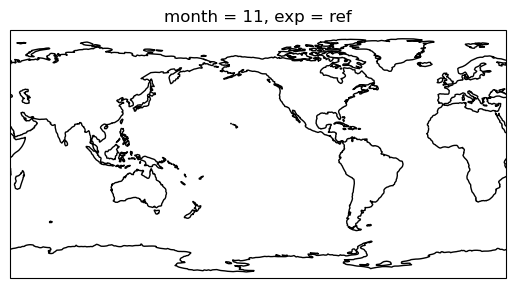

In [17]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=220))
SSTdata.SST.sel(exp='ref',month=11).plot.contour(ax=ax, levels=[25], transform=ccrs.PlateCarree())
ax.coastlines()

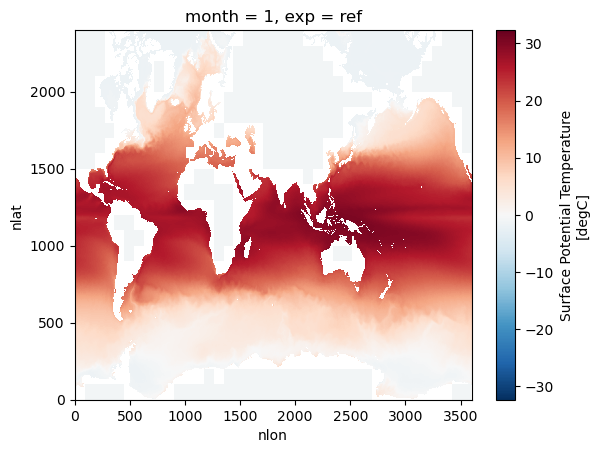

In [20]:
SSTdata.isel(month=0,exp=0).SST.plot()

../figures/fig01.pdf already exists, cannot overwrite


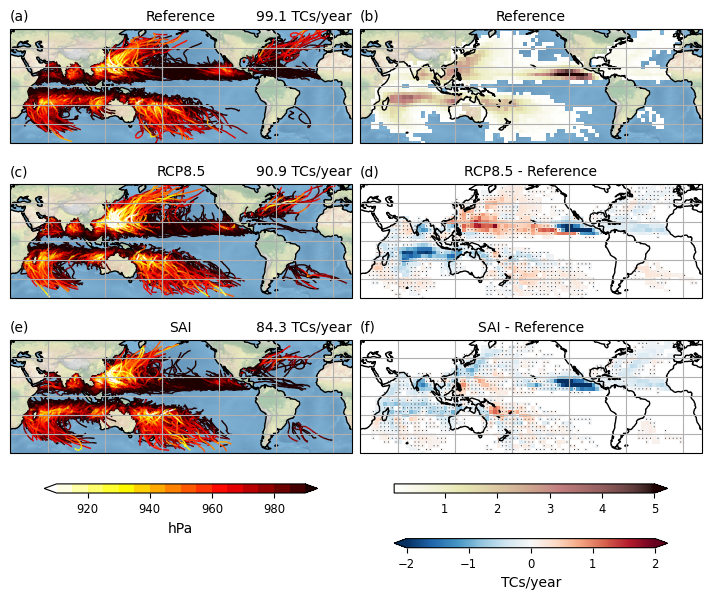

In [22]:
kwargs = dict(transform=ccrs.PlateCarree(), add_colorbar=False)
cbkwargs = dict(orientation='horizontal', aspect=30, shrink=0.8)
titles = {
    '(a)': 'Reference',
    '(b)': 'Reference',
    '(c)': 'RCP8.5',
    '(d)': 'RCP8.5 - Reference',
    '(e)': 'SAI',
    '(f)': 'SAI - Reference'
}

fig, axs = plt.subplots(3,2, sharex=True, sharey=True, layout='constrained', 
                        figsize=(7,6), # (width, height (in))
                        subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)},
                       )
                        # gridspec_kw={'hspace':0.12})

############ tracks ################
cmap = plt.get_cmap('hot_r')
for exp, ax in zip(ds, axs[:,0]):
    for clevid, segs in segments[exp].items():
        color = cmap((clevid-0.5)/(Nv))
        ax.add_collection(LineCollection(segs, color=color, lw=1, 
            transform=ccrs.PlateCarree(), capstyle='butt'))
    # ax.set_title(exp)
    ax.set_title(f"{ds[exp].id.size/ds[exp].num_days*365:.1f} TCs/year", loc='right')

# colormap tracks
colors = cmap((np.arange(Nv+1)-0.5)/Nv)
lcmap = ListedColormap(colors[1:-1])
lcmap.set_extremes(under=colors[0], over=colors[-1], bad=cmap.get_bad())
cb = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin,vmax=vmax),cmap=lcmap), 
             ax=axs[:,0], extend='both', **cbkwargs)
cb.ax.set_xlabel('hPa')

############ track density #############

ax = axs[0,1] # ref. track density
cfdata = hists['Reference'].hcount.mean('x')
cfdata.data[cfdata==0] = np.nan
cf_ref = cfdata.plot(ax=ax, vmax=5, cmap='pink_r', **kwargs)
# ax.set_title("Reference")

ax = axs[1,1] # RCP-Ref track density
cfdata = (hists['RCP8.5'].hcount.mean('x')
          -hists['Reference'].hcount.mean('x'))
cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, vmin=-2, vmax=2, cmap='RdBu_r', **kwargs)
# ax.set_title("RCP8.5 - Reference")

# significance
sig = np.sqrt(stderr['RCP8.5']**2+stderr['Reference']**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (2*sig), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())

ax = axs[2,1] # SAI-Ref track density
cfdata = (hists['SAI2050'].hcount.mean('x')
          -hists['Reference'].hcount.mean('x'))
cfdata.data[cfdata==0] = np.nan
cf = cfdata.plot(ax=ax, vmin=-2, vmax=2, cmap='RdBu_r', **kwargs)
# ax.set_title("SAI2050 - Reference")

# significance
sig = np.sqrt(stderr['SAI2050']**2+stderr['Reference']**2)/np.sqrt(2)
mask = xr.where(np.abs(cfdata) < (2*sig), True, False).transpose('xbins','ybins')
x,y = np.meshgrid(mask.xbins, mask.ybins, indexing='ij')
si = ax.scatter(x[mask], y[mask], s=0.5, c='k', edgecolors='none', transform=ccrs.PlateCarree())

cb = fig.colorbar(cf, ax=axs[:,1], extend='both', **cbkwargs)
cb.ax.set_xlabel('TCs/year')
cb = fig.colorbar(cf_ref, ax=axs[:,1], extend='max', **cbkwargs)

for ax,(ref,title) in zip(axs.flat, titles.items()):
    ax.set_title(title)
    ax.set_title(ref, loc='left')
    ax.coastlines()
    ax.gridlines()
    ax.set_extent((-180,180,-60,60), crs=ccrs.PlateCarree())
for ax in [*axs[:,0], axs[0,1]]:
    ax.stock_img()

savefig(fig, "fig01.pdf", bbox_inches='tight', transparent=True)

In [193]:
# def add_cyclic(da):
#     """convenience wrapper for cartopy.util.add_cyclic for xarray"""
#     lats, lons = xr.broadcast(da.lat, da.lon)
#     cdata, clons, clats = cutil.add_cyclic(da, lons, lats)
#     ccoords = {c: da[c] for c in da.coords}
#     ccoords['lon'] = (lons.dims, clons, lons.attrs)
#     ccoords['lat'] = (lats.dims, clats, lats.attrs)
#     return xr.DataArray(cdata, ccoords, da.dims)


# # ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
# lons = np.linspace(0,359,360)
# lats = np.linspace(-90,90,181)
# da = (np.cos(lats/45*np.pi) + 1.5)[:,None] * (np.cos(lons/180*np.pi))[None,:]
# da = xr.DataArray(da, [('lat',lats),('lon',lons)])
# da = add_cyclic(da)


# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=200))
# da.plot.contourf(ax= ax, transform=ccrs.PlateCarree())
# cs = da.plot.contour(ax=ax, levels=[-2,-1,1,2], transform=ccrs.PlateCarree())

import json

with open('segments.txt','w') as f:
    allsegs_list = {str(c): [list(s) for s in segs] for c,segs in zip(cs.levels,allsegs)}
    json.dump(allsegs_list, f)

with open('segments.txt','r') as f:
    allsegs_read = json.load(f)

In [194]:
allsegs_read == allsegs_list


True

saving figures/fig02.pdf...


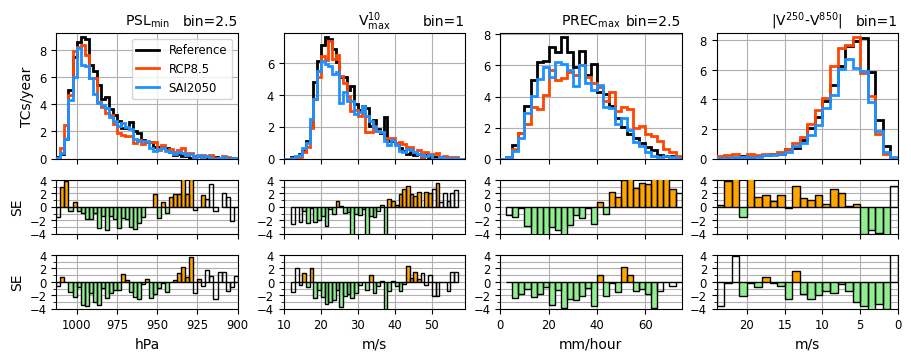

In [72]:
hist_kwargs = {
    'lon': {'bins': np.arange(0,361,10), 'title': 'longitude', 'rev':False},
    'lat': {'bins': np.arange(-45,45.1,2.5), 'title': 'latitude', 'rev':False},
    'PSL': {'bins': np.arange(900,1015,2.5), 'title': 'PSL$_{\mathrm{min}}$', 'rev':True},
    'PSLmon': {'bins': np.arange(995,1025,1), 'title': 'PSL$_{\mathrm{monthly}}$', 'rev':True},
    'U10': {'bins': np.arange(10,60,1), 'title': 'V$^{10}_{\mathrm{max}}$', 'rev':False},
    'RMW': {'bins': np.arange(20,150,5), 'title': 'RMW$^{10}$', 'rev':True}, 
    'SST': {'bins': np.arange(22,34,0.25), 'title': 'SST', 'rev':False},
    'SSTmon': {'bins': np.arange(22,34,0.25), 'title': 'monthly SST', 'rev':False},
    'RV': {'bins': np.arange(4e-4,4e-3,1e-4), 'title': 'RV$^{850}$', 'rev':False},
    'Vshear': {'bins': np.arange(0,25,1), 'title': '|V$^{250}$-V$^{850}$|', 'rev':True},
    'PRECT':{'bins': np.arange(0,76,2.5), 'title': 'PREC$_{\mathrm{max}}$', 'rev':False},
    'TEMP': {'bins': np.arange(0,10,0.25), 'title': '$\Delta$T$^{850}$', 'rev':False},
}

yunits_opts = ['TCs/year','SE']
yunits = yunits_opts[1]  # toggle for selection y units (only changes difference plots)
# method = 'maxRV'         # reduction method (passed to track_stat)
plot_vars = ['PSL','U10','PRECT','Vshear'] # list of variables to plot, one for each column
exps = [list(ds), ['RCP8.5-Reference'], ['SAI2050-Reference']] # list of lists : experiments to include per row (see default_kwargs)

fname = f"figures/fig02.pdf"
fig,axs = plt.subplots(3,4, height_ratios=(7,3,3), figsize=(9,3.5), sharex='col', layout='constrained', subplot_kw=dict(xmargin=0, ymargin=0.03))

# ds_max = {exp: track_stat(ds[exp], method) for exp in ds}
for col,var in enumerate(plot_vars):
    ds_max = {exp: track_stat(ds[exp], 
        'develop' if var=='Vshear' else 'maxRV') for exp in ds}
    hists = {exp: histogram(ds_max[exp][var], hist_kwargs[var]['bins']) for exp in ds_max}
    for row,exp in enumerate(exps):
        title = default_kwargs[exp[0]]['label'] if len(exp)==1 else hist_kwargs[var]['title']
        if row==0:
            axs[row,col].set_title(title)
        plot_histogram(axs[row,col], hists, exp, yunits=yunits)   
    axs[2,col].set_xlabel(ds_max['Reference'][var].units)
    axs[2,col].sharey(axs[1,col])
    if hist_kwargs[var]['rev']:
        axs[2,col].invert_xaxis()
    
for row,exp in enumerate(exps):
    axs[row,0].set_ylabel(yunits if '-' in exp[0] else yunits_opts[0])
axs[0,0].legend()

savefig(fig, fname, bbox_inches='tight', transparent=True)

In [7]:
def tab_print(name, dom, meth, stat, vals, ci, units):
    if isinstance(vals, list) and isinstance(vals[0], str):
        print(f"{name:8s} | {dom:6s} | {meth:7s} | {stat:9s} | {vals[0]:^9s} | {vals[1]:^21s} | {vals[2]:^21s} | {ci:^21s} | {units:^15s}")
    elif isinstance(vals, dict):
        ds = 6 if name == 'RV' else 3
        RCPpart = f"{vals['RCP8.5']:9.{ds}f} ({vals['RCP8.5']-vals['Reference']:+9.{ds}f})"
        if vals['RCP8.5'] > ci[1] or vals['RCP8.5'] < ci[0]:
            RCPpart = f"\033[34m" + RCPpart + f"\033[0m"
        SAIpart = f"{vals['SAI2050']:9.{ds}f} ({vals['SAI2050']-vals['Reference']:+9.{ds}f})"
        if vals['SAI2050'] > ci[1] or vals['SAI2050'] < ci[0]:
            SAIpart = f"\033[34m" + SAIpart + f"\033[0m"
        print(f"{name:8s} | {dom:6s} | {meth:7s} | {stat:9s} | {vals['Reference']:9.{ds}f} | "
                  + f"{RCPpart} | {SAIpart} | "
                  + f"[{ci[0]:8.{ds}f} - {ci[1]:8.{ds}f}] | {units:15s}")

def add_rows(name, meth, qs, doms="GLOB"):
    for dom in np.atleast_1d(doms):
        for q in np.atleast_1d(qs):
            data = {exp: 
                select_region(
                    ds_stat[meth][exp], 
                    region=dom
                ) for exp in ds}
            vals = {exp: v[name].quantile(q) for exp,v in data.items()}
            CI = bootstrap(data['Reference'][name], np.quantile, q)
            statname = 'median' if q==0.5 else f"{q*100:.0f} pct"
            units = data['Reference'][name].units
            tab_print(name,dom,meth,statname,vals,CI,units)

In [49]:
round(0,4)

0

In [65]:
def roundtot(x, n=4):
    """round up to total number of digits (not only decimal)"""
    if isinstance(x, xr.DataArray):
        x = x.item()
    if x == 0:
        return round(x,n)
    xpos = x if x>0 else -x
    base = int(np.floor(np.log10(xpos)))
    num = round(x, n-base-1)
    return num if x==xpos else -num



def tab_print(name, dom, meth, stat, vals, ci, units):
    """print a table row"""
    if isinstance(vals, list) and isinstance(vals[0], str):
        print(f"{name:8s} | {dom:6s} | {meth:7s} | {stat:9s} | {vals[0]:^9s} | {vals[1]:^21s} | {vals[2]:^21s} | {ci:^21s} | {units:^15s}")
    elif isinstance(vals, dict):
        RCPpart = f"{roundtot(vals['RCP8.5'],5):9} ({roundtot(vals['RCP8.5']-vals['Reference'],2):+9})"
        SAIpart = f"{roundtot(vals['SAI2050'],5):9} ({roundtot(vals['SAI2050']-vals['Reference'],2):+9})"
        try:
            if vals['RCP8.5'] > ci[1] or vals['RCP8.5'] < ci[0]:
                RCPpart = f"\033[34m" + RCPpart + f"\033[0m"
            
            if vals['SAI2050'] > ci[1] or vals['SAI2050'] < ci[0]:
                SAIpart = f"\033[34m" + SAIpart + f"\033[0m"
        except:
            pass
        print(f"{name:8s} | {dom:6s} | {meth:7s} | {stat:9s} | {roundtot(vals['Reference'],5):9} | "
                  + f"{RCPpart} | {SAIpart} | "
                  + f"[{roundtot(ci[0],5):8} - {roundtot(ci[1],5):8}] | {units:15s}")

def add_rows(name, meth, qs, doms="GLOB"):
    for dom in np.atleast_1d(doms):
        for q in np.atleast_1d(qs):
            data = {exp: 
                select_region(
                    ds_stat[meth][exp], 
                    region=dom
                ) for exp in ds}
            vals = {exp: v[name].quantile(q) for exp,v in data.items()}
            CI = bootstrap(data['Reference'][name], np.quantile, q)
            statname = 'median' if q==0.5 else f"{q*100:.0f} pct"
            units = data['Reference'][name].units
            if name == 'RV':
                vals = {k:1e4*v for k,v in vals.items()}
                ci = [1e4*c for c in ci]
                units = "10^-4 " + units
            tab_print(name,dom,meth,statname,vals,CI,units)

In [66]:
ds_stat = {method: {exp: track_stat(ds[exp], method) for exp in ds} 
           for method in ['min','max','minmax','mean','maxRV','develop','maxdeep']}

tab_print('variable','region','method','stat',['Reference','RCP8.5','SAI2050'],'90% CI (Ref.)','units')
print(139*"-")
add_rows("RV","max",[0.9]); print("")

variable | region | method  | stat      | Reference |        RCP8.5         |        SAI2050        |     90% CI (Ref.)     |      units     
-------------------------------------------------------------------------------------------------------------------------------------------
RV       | GLOB   | max     | 90 pct    |    23.996 |    25.858 (     +1.9) |    23.897 (   +0.099) | [  23.503 -   24.538] | 10^-4 1/s      



In [12]:
ds_stat = {method: {exp: track_stat(ds[exp], method) for exp in ds} 
           for method in ['min','max','minmax','mean','maxRV','develop','maxdeep']}

tab_print('variable','region','method','stat',['Reference','RCP8.5','SAI2050'],'90% CI (Ref.)','units')
print(139*"-")
add_rows("lat","mean",0.5,doms=["NH","SH"]); print("")
add_rows("PSL","min",[0.1,0.05,0.01]); print("")
add_rows("U10","max",[0.9,0.95,0.99]); print("")
add_rows("RMW","min",[0.1,0.05,0.01]); print("")
add_rows("RV","max",[0.9,0.95,0.99]); print("")
add_rows("PRECT","max",[0.9,0.95,0.99]); print("")
add_rows("TEMP","max",[0.9,0.95,0.99]); print("")
add_rows("Vshear","develop",[0.25,0.5,0.75]); print("")
add_rows("PSLmon","develop",[0.25,0.5,0.75]); print("")
add_rows("SSTmon","develop",[0.25,0.5,0.75]); print("")

variable | region | method  | stat      | Reference |        RCP8.5         |        SAI2050        |     90% CI (Ref.)     |      units     
-------------------------------------------------------------------------------------------------------------------------------------------
lat      | NH     | mean    | median    |    13.955 |    14.586 (   +0.631) |    13.591 (   -0.364) | [  13.605 -   14.255] | degrees_north  
lat      | SH     | mean    | median    |   -17.108 |   -19.080 (   -1.973) |   -17.392 (   -0.285) | [ -17.484 -  -16.735] | degrees_north  

PSL      | GLOB   | min     | 10 pct    |   955.211 |   946.904 (   -8.307) |   952.328 (   -2.883) | [ 953.822 -  956.372] | hPa            
PSL      | GLOB   | min     | 5 pct     |   945.040 |   933.882 (  -11.158) |   939.610 (   -5.430) | [ 943.407 -  946.777] | hPa            
PSL      | GLOB   | min     | 1 pct     |   921.388 |   906.839 (  -14.549) |   917.971 (   -3.417) | [ 917.268 -  926.868] | hPa            

U10   

In [55]:
regions = ['GLOB','NH','SH',*list(domains)]

tab_print('variable','region','method','stat',['Reference','RCP8.5','SAI2050'],'90% CI (Ref.)','units')
print(139*"-")
for dom in regions:
    counts = {exp: select_region(ds[exp], dom).id.groupby(['ens','year']).count().stack(x=['year','ens']) for exp in ds}
    count = {exp: counts[exp].mean('x') for exp in counts}
    stderr = counts['Reference'].std('x',ddof=1)/np.sqrt(counts['Reference'].x.size)
    sig = (count['Reference']-2*stderr, count['Reference']+2*stderr)
    tab_print('num',dom,'-','count',count,sig,'TCs/year')
print("")
add_rows("lat","mean",0.5,doms=regions); print("")
add_rows("PSL","min",0.1,doms=regions); print("")
add_rows("U10","max",0.9,doms=regions); print("")
add_rows("RMW","min",0.1,doms=regions); print("")
add_rows("RV","max",0.9,doms=regions); print("")
add_rows("PRECT","max",0.9,doms=regions); print("")
add_rows("TEMP","max",0.9,doms=regions); print("")
add_rows("Vshear","develop",0.5,doms=regions); print("")
add_rows("PSLmon","develop",0.5,doms=regions); print("")
add_rows("SSTmon","develop",0.5,doms=regions); print("")

variable | region | method  | stat      | Reference |        RCP8.5         |        SAI2050        |     90% CI (Ref.)     |      units     
-------------------------------------------------------------------------------------------------------------------------------------------
num      | GLOB   | -       | count     |    99.120 |    90.880 (   -8.240) |    84.280 (  -14.840) | [  94.779 -  103.461] | TCs/year       
num      | NH     | -       | count     |    54.640 |    53.360 (   -1.280) |    41.920 (  -12.720) | [  50.629 -   58.651] | TCs/year       
num      | SH     | -       | count     |    44.480 |    37.520 (   -6.960) |    42.360 (   -2.120) | [  42.119 -   46.841] | TCs/year       
num      | NA     | -       | count     |     3.522 |     2.588 (   -0.934) |     2.647 (   -0.875) | [   2.732 -    4.311] | TCs/year       
num      | SA     | -       | count     |     1.000 |     1.500 (   +0.500) |     1.000 (   +0.000) | [   1.000 -    1.000] | TCs/year       
num     

To do table:
- only show median and mean of 10% extremest values (only median for environment vars)
- SST instead of SSTmon
- no PSLmon
- think about RV, TEMP and RMW, relevant enough for main?
- choose between absolute value, change and percentual change for exps
- reorder basins appendix (NH basins + NH, SH basins + SH)
- fewer digits (scale to scientific format, then format and scale back)
- RV in 10^-4 1/s